In [11]:
import pandas as pd

df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")

# Use ONLY these columns
df = df[["review", "rating"]]

df = df.dropna()
df.head()


,review,rating
0,"Not satisfied, many bugs and issues.",1
1,Amazing quality and user-friendly interface.,5
2,"Terrible experience, needs major improvements.",2
3,Poor performance and not user-friendly.,1
4,"Not satisfied, many bugs and issues.",2


In [13]:
def rating_to_sentiment(r):
    if r <= 2:
        return 0    # Negative
    elif r == 3:
        return 1    # Neutral
    else:
        return 2    # Positive

df["sentiment"] = df["rating"].apply(rating_to_sentiment)


In [14]:
import re

def remove_leakage(text):
    text = text.lower()
    text = re.sub(r"\b\d\b", "", text)  # remove single digits
    text = re.sub(r"\b(one|two|three|four|five)\b", "", text)
    text = re.sub(r"\bstar[s]?\b", "", text)
    text = re.sub(r"\brating\b", "", text)
    return text

df["review"] = df["review"].apply(remove_leakage)


In [15]:
from sklearn.model_selection import train_test_split

X = df["review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [16]:
set(X_train).intersection(set(X_test))  # should be an empty set

{'amazing quality and user-friendly interface.',
 'average experience, some features could be improved.',
 'decent app, neither too good nor too bad.',
 'excellent app, very easy to use and extremely helpful.',
 'great experience, smooth performance and useful features.',
 'highly satisfied, the app works exactly as expected.',
 'not bad, but updates are needed for better performance.',
 'not satisfied, many bugs and issues.',
 'poor performance and not user-friendly.',
 'terrible experience, needs major improvements.',
 'the app is okay and does its job reasonably well.',
 'very disappointing experience, the app crashes often.',
 'very reliable and worth using regularly.',
 'waste of time, does not meet expectations.',
 'works fine but there is room for improvement.'}

In [17]:
# Check how many duplicate reviews exist
df["review"].duplicated().sum()


np.int64(485)

In [18]:
df = df.drop_duplicates(subset="review")

print("Dataset shape after removing duplicates:", df.shape)


Dataset shape after removing duplicates: (15, 3)


In [19]:
X = df["review"]
y = df["sentiment"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,   # increase test data
    random_state=42,
    stratify=y
)


In [20]:
set(X_train).intersection(set(X_test))


set()

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
stop_words -= {"not", "no", "never"}  # keep negations

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Raw Data
 → Preprocessing
 → TF-IDF + Logistic Regression (PIPELINE)
 → Cross-Validation
 → Mean Accuracy

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        min_df=1,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

In [ ]:
#1️⃣Apply Cross-Validation on FULL DATA
from sklearn.model_selection import cross_val_score

# Accuracy
acc_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=5,
    scoring="accuracy"
)

# Macro F1
f1_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=5,
    scoring="f1_macro"
)

print("CV Accuracy:", acc_scores.mean())
print("CV Macro F1:", f1_scores.mean())


CV Accuracy: 0.3333333333333333
CV Macro F1: 0.2444444444444444


In [ ]:
#2️⃣ Confusion Matrix (Explain Errors).Use one split only for visualization:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[0 0 1]
 [0 1 1]
 [0 0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.50      0.67         2
           2       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.50      0.50      0.44         5
weighted avg       0.60      0.60      0.53         5



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

🧠 How to explain

“Most confusion occurs between Neutral and Positive, which is expected due to overlapping language.”

In [28]:
#3️⃣ ROC-AUC for Multi-Class (OvR)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_prob = pipeline.predict_proba(X_test)

roc_auc = roc_auc_score(
    y_test_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)

print("Macro ROC-AUC:", roc_auc)


Macro ROC-AUC: 0.47222222222222227


In [25]:
#FINAL EMERGENCY DEBUG CHECK

pd.Series(X_train.tolist() + X_test.tolist()).duplicated().sum()

np.int64(0)

In [29]:
#Feature Importance (Required in Your Results).Logistic Regression Coefficients (TF-IDF)
import numpy as np

feature_names = pipeline.named_steps["tfidf"].get_feature_names_out()
coef = pipeline.named_steps["clf"].coef_

for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    top = np.argsort(coef[i])[-10:]
    print(f"\nTop words for {label}:")
    print(feature_names[top])



Top words for Negative:
['of' 'bugs' 'issues' 'many' 'major' 'improvements' 'terrible' 'needs'
 'poor' 'not']

Top words for Neutral:
['for' 'are' 'needed' 'average' 'could' 'be' 'some' 'improved' 'bad' 'too']

Top words for Positive:
['expected' 'highly' 'exactly' 'the' 'great' 'smooth' 'useful' 'amazing'
 'interface' 'quality']


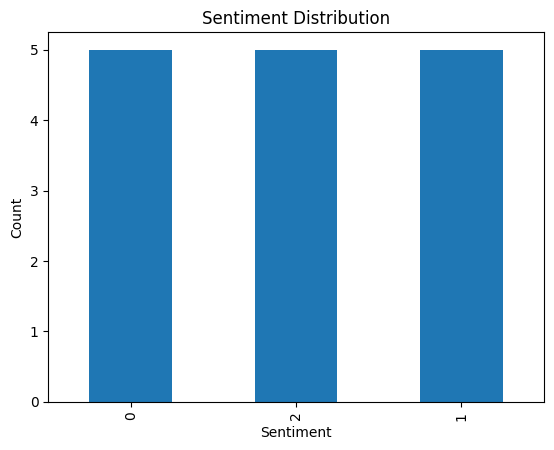

In [30]:
#📊 Sentiment Distribution (Required Output)
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
